In [ ]:
pip install spacy

In [ ]:
pip install catboost

     |████████████████████████████████| 76.6 MB 1.2 MB/s 


# Project for "Wikishop"

Wikishop online store launches a new service. Now users can edit and supplement product descriptions, as in wiki communities. That is, clients offer their edits and comment on the changes of others. The store needs a tool that will search for toxic comments and send them for moderation.

**Data description**

The data is in the file 'toxic_comments.csv'. The *text* column in it contains the comment text, and *toxic* is the target attribute.

<h1>Table of contents<span class="tocSkip"></span></h1>

<div class="toc"><ul class="toc-item"><li><span><a href="#Preprocessing" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Train" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Conclusions" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Testing</a></span></li></ul></div>

## 1. Preprocessing

In [ ]:
import re
import pandas as pd
import numpy as np
import nltk
import warnings
import spacy
import matplotlib.pyplot as plt


from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score
from sklearn.utils import shuffle

warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('toxic_comments.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [ ]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [ ]:
df.isna().sum()

text     0
toxic    0
dtype: int64

In [ ]:
df['text'].duplicated().sum()

0

In [ ]:
df.toxic.value_counts()
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
print('Toxic comments are {:2.2f} %'.format(df['toxic'].value_counts()[1] / len(df) * 100))
print('Non-toxic comments vs. toxic {:2.2f} : 1'.format(class_ratio))

Toxic comments are 10.17 %
Non-toxic comments vs. toxic 8.83 : 1


In [ ]:
df.shape

(159571, 2)

There is an imbalance of classes. To balance classes, consider the following methods:

1. Changing weights in a machine learning model;

2. Resampling with class 0 reduction.

Due to the large amount of data, we will refuse to resample with an increase in class 1.

We will prepare the signs for further training.

In [ ]:
%%time

nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatize_text(text):
  doc = nlp(text)
  lemm_text = " ".join([token.lemma_ for token in doc])
  cleared_text = re.sub(r'[^a-zA-Z]', ' ', lemm_text)
  return " ".join(cleared_text.split())

df['lemm_text'] = df['text'].apply(lemmatize_text)

df = df.drop(['text'], axis=1)

CPU times: user 14min 49s, sys: 6.2 s, total: 14min 55s
Wall time: 14min 56s


In [ ]:
df.head()

,toxic,lemm_text
0,0,explanation why the edit make under PRON usern...
1,0,d aww PRON match this background colour PRON b...
2,0,hey man PRON be really not try to edit war PRO...
3,0,More PRON can not make any real suggestion on ...
4,0,PRON sir be PRON hero any chance PRON remember...


In [ ]:
df.shape

(159571, 2)

Given the size of our data, we will split the sample in the proportion of 60:20:20.

In [ ]:
# We will allocate training, validation and test samples in the proportion of 60:20:20
target = df['toxic']
features = df.drop(['toxic'], axis=1)

# Let's check TF-IDF for sample attributes taking into account stopwords 
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
                                                                            

count_tf_idf = TfidfVectorizer(stop_words=stopwords)
features = count_tf_idf.fit_transform(features['lemm_text'].astype('U'))



print(target.shape)
print(features.shape)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.4,
                                                                            random_state=69)
features_valid,  features_test, target_valid, target_test = train_test_split(features_valid, target_valid, test_size=0.5,random_state=69)
 
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)
cv_counts=3

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
(159571,)
(159571, 158013)
(95742, 158013)
(31914, 158013)
(31915, 158013)


In [ ]:
%%time 

log_model = LogisticRegression()
train_f1 = cross_val_score(log_model,
                           features_train,
                           target_train,
                           cv=cv_counts,
                           scoring='f1').mean()

print('F1 on cross-validation using logistic regression:', train_f1)

F1 on cross-validation using logistic regression: 0.6878456598692059
CPU times: user 18.2 s, sys: 18.7 s, total: 36.9 s
Wall time: 19.2 s


<div style="font-size: 20px">
    

**1.1 Changing the balance of classes**

<div style="font-size: 15px">
    

**1.1.1 Changing class weights**

In [ ]:
%%time

dict_classes = {0:1, 1:class_ratio}
log_model_2 = LogisticRegression(class_weight=dict_classes)
train_f1_balanced = cross_val_score(log_model_2,
                                    features_train,
                                    target_train,
                                    cv=cv_counts,
                                    scoring='f1').mean()
print('F1 on cross-validation with balanced classes', train_f1_balanced)


F1 on cross-validation with balanced classes 0.7508005183027824
CPU times: user 20.7 s, sys: 21.9 s, total: 42.6 s
Wall time: 22 s


In [ ]:
%%time

log_model_3 = LogisticRegression(class_weight='balanced')
train_f1_balanced = cross_val_score(log_model_3,
                                    features_train,
                                    target_train,
                                    cv=cv_counts,
                                    scoring='f1').mean()
print('F1 on cross-validation with balanced classes', train_f1_balanced)

F1 on cross-validation with balanced classes 0.7429775260514909
CPU times: user 16.8 s, sys: 17.1 s, total: 33.9 s
Wall time: 17.6 s


F1 метрика увеличилась. Встроенный метод повторяет значение F1.

<div style="font-size: 15px">
    

**1.1.2 Resampling with class 0 reduction**

Let's try to restore the balance of classes by making the number of entries with class 0 the same as with class 1.

In [ ]:
toxic_comments_train = df.iloc[target_train.index]

target_train_class_zero = toxic_comments_train[toxic_comments_train['toxic'] == 0]['toxic']
target_train_class_one = toxic_comments_train[toxic_comments_train['toxic'] == 1]['toxic']

In [ ]:
target_train_class_zero_downsample = target_train_class_zero.sample(target_train_class_one.shape[0],
                                                                    random_state=69)
target_train_downsample = pd.concat([target_train_class_zero_downsample, target_train_class_one])

features_train_downsample = df.iloc[target_train_downsample.index]
features_train_downsample, target_train_downsample = shuffle(features_train_downsample, target_train_downsample, random_state=69)
features_train_downsample = count_tf_idf.transform(features_train_downsample['lemm_text'].values.astype('U'))

del count_tf_idf
del stopwords

In [ ]:
log_model_4 = LogisticRegression()
train_f1_downsampled = cross_val_score(log_model_4,
                                       features_train_downsample,
                                       target_train_downsample,
                                       cv=cv_counts,
                                       scoring='f1').mean()
print('F1 on cross-validation with decreasing classes', train_f1_downsampled)

F1 on cross-validation with decreasing classes 0.8783429819674095


The increase in the metric is noticeable. Let's build ROC-AUC graphs and look at the table of balanced results.

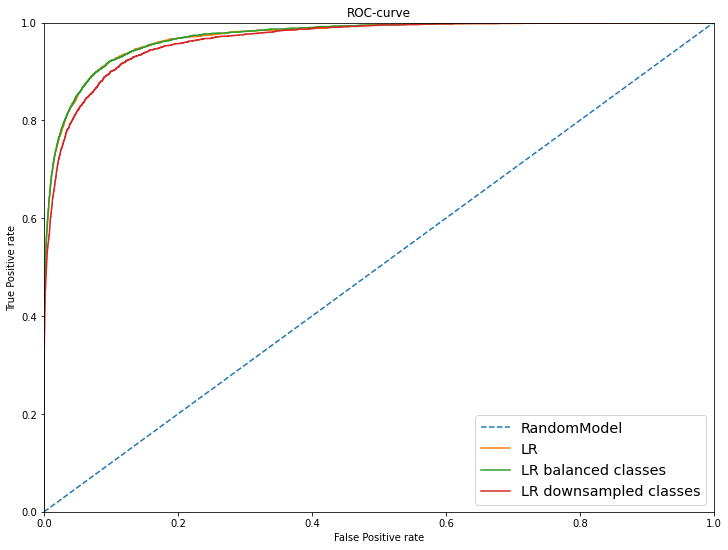

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0,1],[0,1], linestyle = '--', label='RandomModel')


log_model_4 = LogisticRegression()
log_model_4.fit(features_train, target_train)
probabilities_valid = log_model_4.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, threshold = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1 = f1_score(target_valid, log_model_4.predict(features_valid))
plt.plot(fpr, tpr, label='LR')

log_model_5 = LogisticRegression(class_weight=dict_classes)
log_model_5.fit(features_train, target_train)
probabilities_valid = log_model_5.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_balanced = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_balanced = f1_score(target_valid, log_model_5.predict(features_valid))
plt.plot(fpr, tpr, label='LR balanced classes')

log_model_6 = LogisticRegression()
log_model_6.fit(features_train_downsample, target_train_downsample)
probabilities_valid = log_model_6.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc_downsampled = roc_auc_score(target_valid, probabilities_one_valid)
valid_f1_downsampled = f1_score(target_valid, log_model_6.predict(features_valid))
plt.plot(fpr,tpr, label='LR downsampled classes')

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')

plt.legend(loc='lower right', fontsize='x-large')

plt.title('ROC-curve')
plt.show()

In [ ]:
index= ['LogisticRegression',
        'LR balanced classes',
        'LR downsampled classes']

data = {'F1 on CV':[train_f1,
                    train_f1_balanced,
                    train_f1_downsampled],
        'F1 on validation':[valid_f1,
                           valid_f1_balanced,
                           valid_f1_downsampled],
       'AUC-ROC':[auc_roc,
                  auc_roc_balanced,
                  auc_roc_downsampled]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data

,F1 on CV,F1 on validation,AUC-ROC
LogisticRegression,0.687846,0.709063,0.971027
LR balanced classes,0.742978,0.757228,0.971567
LR downsampled classes,0.878343,0.699010,0.964895


The method of balancing by weight proved to be the most effective. We will leave it for further use, and delete the rest.

In [ ]:
del toxic_comments_train
del target_train_class_zero
del target_train_class_one
del target_train_class_zero_downsample
del target_train_downsample
del features_train_downsample

<div style="font-size: 15px">
    

**Intermediate conclusion**

At the first step, the data was preprocessed and divided into the training, validation and test samples.

The best metrics of F1 and AUC-ROC were shown by a classifier that takes into account the weight of classes. In training, we will use this method of balancing classes.

## 2. Training

Let's train the following models:

1. LogisticRegression;

2. DecisionTreeClassifier;

3. CatBoostClassifier;

4. SGDClassifier.


<div style="font-size: 20px">
    

**2.1 LogisticRegression**

In [ ]:
%%time

log_model_7 = LogisticRegression()
hyperparams = [{'solver':['lbfgs', 'liblinear'],
                'C':[0.1, 1, 10],
                'class_weight':[dict_classes]}]

print('# Selection of hyperparameters for f1_score')
print()
clf = GridSearchCV(log_model_7, hyperparams, scoring='f1', cv=cv_counts)
clf.fit(features_train, target_train)
print('Best parameters')
print()
LR_best_params = clf.best_params_
print(LR_best_params)
print()
print('Grid scores')
print()
means=clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_LR = max(means)

# Selection of hyperparameters for f1_score

Best parameters

{'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

Grid scores

0.707389 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.707389 for {'C': 0.1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.750801 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.750378 for {'C': 1, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}
0.760174 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'lbfgs'}
0.760671 for {'C': 10, 'class_weight': {0: 1, 1: 8.834884437596301}, 'solver': 'liblinear'}

CPU times: user 1min 20s, sys: 1min 23s, total: 2min 43s
Wall time: 1min 25s


In [ ]:
%%time

log_model_8 = LogisticRegression()
log_model_8.set_params(**LR_best_params)
log_model_8.fit(features_train, target_train)
target_predict = log_model_8.predict(features_valid)
valid_f1_LR  = f1_score(target_valid, target_predict)
print('F1 on CV', cv_f1_LR)
print('F1 on validation', valid_f1_LR)

F1 on CV 0.7606711695918985
F1 on validation 0.7638235294117648
CPU times: user 6.3 s, sys: 4.04 s, total: 10.3 s
Wall time: 5.36 s


<div style="font-size: 20px">
    

**2.2 DecisionTreeClassifier**

In [ ]:
%%time

tree_model = DecisionTreeClassifier()
hyperparams = [{'max_depth':[x for x in range(30, 51, 2)],
                'random_state':[69],
                'class_weight':[dict_classes]}]

print('# Selection of hyperparameters for f1_score')
print()
clf = GridSearchCV(tree_model, hyperparams,scoring='f1', cv=cv_counts)
clf.fit(features_train, target_train)
print('Best parameters')
print()
DTC_best_params = clf.best_params_
print(DTC_best_params)
print()
print('Grid scores')
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print('%0.6f for %r'% (mean, params))
print()

cv_f1_DTC = max(means)

# Selection of hyperparameters for f1_score

Best parameters

{'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 42, 'random_state': 69}

Grid scores

0.637266 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 30, 'random_state': 69}
0.637810 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 32, 'random_state': 69}
0.643783 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 34, 'random_state': 69}
0.650803 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 36, 'random_state': 69}
0.652199 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 38, 'random_state': 69}
0.655555 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 40, 'random_state': 69}
0.657132 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 42, 'random_state': 69}
0.640863 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max_depth': 44, 'random_state': 69}
0.620450 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'max

In [ ]:
%%time

tree_model_2 = DecisionTreeClassifier()
tree_model_2.set_params(**DTC_best_params)
tree_model_2.fit(features_train, target_train)
target_predict = tree_model_2.predict(features_valid)
valid_f1_DTC = f1_score(target_valid, target_predict)
print('F1 on CV', cv_f1_DTC)
print('F1 on validation', valid_f1_DTC)

F1 on CV 0.6571320050097254
F1 on validation 0.6208033573141487
CPU times: user 44.7 s, sys: 28.3 ms, total: 44.7 s
Wall time: 44.6 s


<div style="font-size: 20px">
    

**2.2 CatBoostClassifier**

In [ ]:
%%time

cat_model = CatBoostClassifier(verbose=False, iterations=200)
cat_model.fit(features_train, target_train)
target_predict = cat_model.predict(features_valid)
cv_f1_CBC = cross_val_score(cat_model,
                            features_train,
                            target_train,
                            cv=cv_counts,
                            scoring='f1').mean()
valid_f1_CBC = f1_score(target_valid, target_predict)
print('F1 on cross-validation', cv_f1_CBC)
print('F1 on validation', valid_f1_CBC)

F1 on cross-validation 0.7358458939895437
F1 on validation 0.736247723132969
CPU times: user 35min 7s, sys: 11.7 s, total: 35min 19s
Wall time: 18min 57s


<div style="font-size: 20px">
    

**2.2 SGDClassifier**

In [ ]:
%%time

sgd_model = SGDClassifier()
hyperparams = [{'loss':['hinge', 'log', 'modified_huber'],
                'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                'random_state':[69],
                'class_weight':[dict_classes]}]

print('# Selection of hyperparameters for f1_score')
print()
clf = GridSearchCV(sgd_model, hyperparams, scoring='f1', cv=cv_counts)
clf.fit(features_train, target_train)
print('Best parameters')
print()
SGDC_best_params = clf.best_params_
print(SGDC_best_params)
print()
print('Grid scores')
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.6f for %r"% (mean, params))
print()

cv_f1_SGDC = max(means)

# Selection of hyperparameters for f1_score

Best parameters

{'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'adaptive', 'loss': 'modified_huber', 'random_state': 69}

Grid scores

0.735408 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'hinge', 'random_state': 69}
0.715052 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'log', 'random_state': 69}
0.753387 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'constant', 'loss': 'modified_huber', 'random_state': 69}
0.737349 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'hinge', 'random_state': 69}
0.718462 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_rate': 'optimal', 'loss': 'log', 'random_state': 69}
0.747957 for {'class_weight': {0: 1, 1: 8.834884437596301}, 'eta0': 0.01, 'learning_r

In [ ]:
%%time

sgd_model_2 = SGDClassifier()
sgd_model_2.set_params(**SGDC_best_params)
sgd_model_2.fit(features_train, target_train)
target_predict = sgd_model_2.predict(features_valid)
valid_f1_SGDC = f1_score(target_valid, target_predict)
print('F1 on cross-validation', cv_f1_SGDC)
print('F1 on validation', valid_f1_SGDC)

F1 on cross-validation 0.7573520471000483
F1 on validation 0.760500695410292
CPU times: user 2.12 s, sys: 67.3 ms, total: 2.19 s
Wall time: 2.13 s


Let's look at the test results on the validation sample for the best models.

In [ ]:
index = ['LogisticRegression',
         'DecisionTreeClassifier',
         'CatBoostClassifier',
         'SGDClassifier']
data = {'F1 on cross-validation':[cv_f1_LR,
                                 cv_f1_DTC,
                                 cv_f1_CBC,
                                 cv_f1_SGDC],
        'F1 on validation':[valid_f1_LR,
                           valid_f1_DTC,
                           valid_f1_CBC,
                           valid_f1_SGDC]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Task completion'] = scores_data['F1 on validation'] > 0.75
scores_data

,F1 on cross-validation,F1 on validation,Task completion
LogisticRegression,0.760671,0.763824,True
DecisionTreeClassifier,0.657132,0.620803,False
CatBoostClassifier,0.735846,0.736248,False
SGDClassifier,0.757352,0.760501,True


<div style="font-size: 15px">
    

**Intermediate conclusion**

Since the LogisticRegression and SGDClassifier models showed the best metrics of F1 metric on the validation sample, we will use them on the test sample.

## 3. Testing

Let's check the metrics F1, Precision, Recall, Accuracy and AUC-ROC.

Метрики LogisticRegression
AUC-ROC 0.9665153776738142
F1 0.7570705567133076
Precision 0.7220329358319136
Recall 0.7956821026282853
Accuracy 0.9488641704527652

Метрики SGDCClassifier
AUC-ROC 0.9705658026605473
F1 0.753932584269663
Precision 0.6839959225280327
Recall 0.8397997496871089
Accuracy 0.9451041829860567



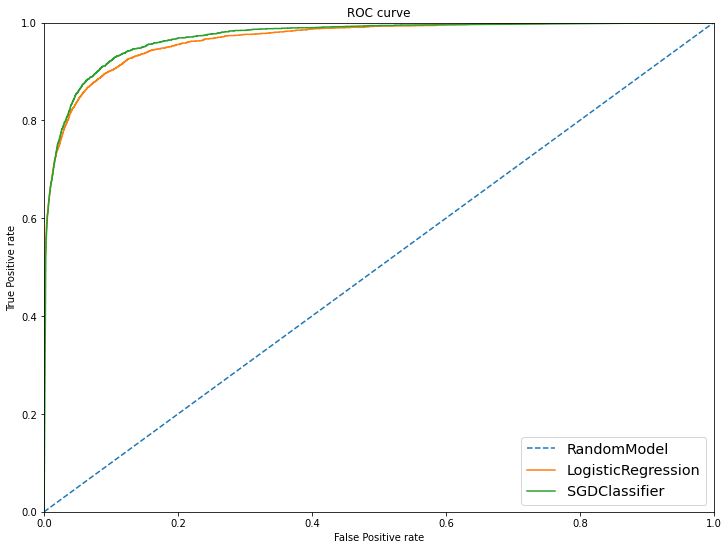

In [ ]:
plt.figure(figsize=[12,9])

plt.plot([0, 1], [0, 1], linestyle='--', label='RandomModel')


log_model_final = LogisticRegression()
log_model_final.set_params(**LR_best_params)
log_model_final.fit(features_train, target_train)
probabilities_test = log_model_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = log_model_final.predict(features_test)
plt.plot(fpr, tpr, label='LogisticRegression')
print('Метрики LogisticRegression')
print('AUC-ROC', roc_auc_score(target_test, probabilities_one_test))
print('F1', f1_score(target_test, predict_test))
print('Precision', precision_score(target_test, predict_test))
print('Recall', recall_score(target_test, predict_test))
print('Accuracy', accuracy_score(target_test, predict_test))
print()

sgd_model_final = SGDClassifier()
sgd_model_final.set_params(**SGDC_best_params)
sgd_model_final.fit(features_train, target_train)
probabilities_test = sgd_model_final.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
predict_test = sgd_model_final.predict(features_test)
plt.plot(fpr, tpr, label='SGDClassifier')
print('Метрики SGDCClassifier')
print('AUC-ROC', roc_auc_score(target_test, probabilities_one_test))
print('F1', f1_score(target_test, predict_test))
print('Precision', precision_score(target_test, predict_test))
print('Recall', recall_score(target_test, predict_test))
print('Accuracy', accuracy_score(target_test, predict_test))
print()

plt.xlim([0,1])
plt.ylim([0,1])

plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")

plt.legend(loc='lower right', fontsize='x-large')

plt.title('ROC curve')
plt.show()

<div style="font-size: 20px">
    

**Final conclusion**

Under this project, original data was preprocessed for futher training on various machine learning models, a method for balancing classes of the target indicator was selected, and training, validation, and test samples were selected on which the models were trained.

The initial data have a large number of features. There are more columns created than the data records themselves.For TF-IDF, the best models were Logistic Regression and SGDClassifier.

In the test sample according to the F1 metric, Logistic Regression showed itself best. This model has the best Precision, Accuracy indicators, then it finds toxic comments better.

SGDClassifier showed the best indicators of AUC-ROC, Recall metrics. The model is capable of processing more records.